In [1]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from scipy.stats import gaussian_kde

from edward.models import Poisson, Gamma, TransformedDistribution, Normal

plt.style.use('ggplot')

In [2]:
ed.set_seed(142)

In [3]:
# Model
N = 100

a = 2.0
b = 1.0
r = Gamma(a, b)
x = Poisson(rate=r, sample_shape=N)

In [4]:
# Data
sess = ed.get_session()
x_data, r_data = sess.run([x, r])

In [5]:
r_data

1.0255443

In [6]:
# True posterior (Gamma is conjugate to Poisson)
true_qr = Gamma(tf.cast(a + np.sum(x_data), tf.float32), tf.cast(b + N, tf.float32))

In [7]:
# Inference
qr = Gamma(tf.nn.softplus(tf.Variable(1.0)), tf.nn.softplus(tf.Variable(1.0)))

inference = ed.KLqp({r: qr}, data={x: x_data})
inference.initialize()

tf.global_variables_initializer().run()

loss = np.empty(inference.n_iter)
for i in range(inference.n_iter):
    info_dict = inference.update()
    inference.print_progress(info_dict)
    loss[i] = info_dict["loss"]

inference.finalize()

/home/pedro/IST/Thesis/edward-venv/lib/python3.5/site-packages/edward/util/random_variables.py:50: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \


1000/1000 [100%] ██████████████████████████████ Elapsed: 4s | Loss: 137.941


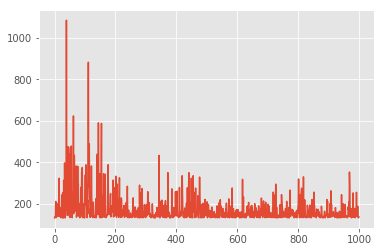

In [8]:
plt.plot(loss)
plt.show()

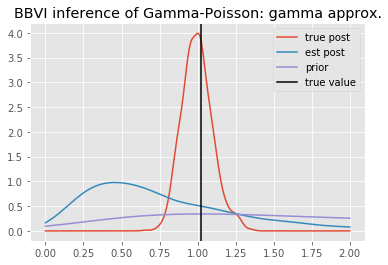

In [9]:
n_samples = 1000

samples_post = qr.sample(n_samples).eval()
samples_prior = r.sample(n_samples).eval()
true_post = true_qr.sample(n_samples).eval()

posterior_density = gaussian_kde(samples_post)
prior_density = gaussian_kde(samples_prior)
true_posterior_density = gaussian_kde(true_post)

xs = np.linspace(0,2,200)
plt.plot(xs, true_posterior_density(xs), label='true post')
plt.plot(xs, posterior_density(xs), label='est post')
plt.plot(xs, prior_density(xs), label='prior')
plt.axvline(x=r_data, c='black', label='true value')
plt.legend()
plt.title('BBVI inference of Gamma-Poisson: gamma approx.')
plt.show()

In [10]:
# Use a log-normal approximation to the Gamma posterior
qr = TransformedDistribution(
    distribution=Normal(tf.Variable(1.0), tf.nn.softplus(tf.Variable(0.1))),
    bijector=tf.contrib.distributions.bijectors.Exp())

inference = ed.KLqp({r: qr}, data={x: x_data})
inference.initialize()

tf.global_variables_initializer().run()

loss = np.empty(inference.n_iter)
for i in range(inference.n_iter):
    info_dict = inference.update()
    inference.print_progress(info_dict)
    loss[i] = info_dict["loss"]

inference.finalize()

/home/pedro/IST/Thesis/edward-venv/lib/python3.5/site-packages/edward/util/random_variables.py:50: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \


1000/1000 [100%] ██████████████████████████████ Elapsed: 4s | Loss: 135.291


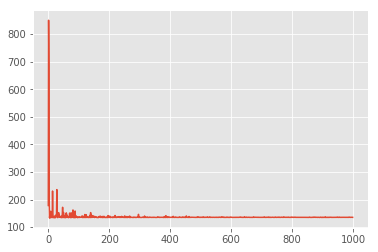

In [13]:
plt.plot(loss)
plt.show()

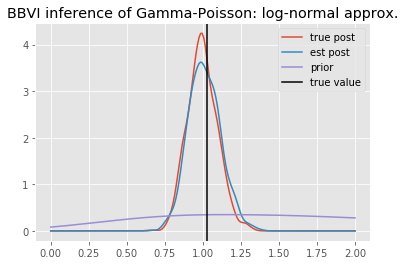

In [11]:
n_samples = 1000

samples_post = qr.sample(n_samples).eval()
samples_prior = r.sample(n_samples).eval()
true_post = true_qr.sample(n_samples).eval()

posterior_density = gaussian_kde(samples_post)
prior_density = gaussian_kde(samples_prior)
true_posterior_density = gaussian_kde(true_post)

xs = np.linspace(0,2,200)
plt.plot(xs, true_posterior_density(xs), label='true post')
plt.plot(xs, posterior_density(xs), label='est post')
plt.plot(xs, prior_density(xs), label='prior')
plt.axvline(x=r_data, c='black', label='true value')
plt.legend()
plt.title('BBVI inference of Gamma-Poisson: log-normal approx.')
plt.show()